In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

## Augmented Wilson-Cowan Model

#### Reference : [1]. Park Y, Geffen MN (2020) A circuit model of auditory cortex. PLoS Comput Biol 16(7): e1008016. https://doi.org/10.1371/journal.pcbi.1008016

Paper[1] consists of an augmented version of Wilson-Cowan model with single unit and three iso-frequency units of Auditory cortex. Each unit consists of one excitatory population and two inhibitory populations of SST and PV each. The different parameters of time constants, firing rate function gain, strength of connections etc used in the model have been constrained based on experimental data results on previous studies. 

In the simulations below, $ u(t), p(t), s(t) $ represents the firing rate responses of Exc, PV and SST populations. Steps for single unit and three unit simulations of models with optogenetic stimulation, stimulus-specific adaptation(SSA) and forward suppression, E_I balance and feedforward functional connectivity have been described below.

![Image of model](https://journals.plos.org/ploscompbiol/article/figure/image?size=medium&id=10.1371/journal.pcbi.1008016.g001)



In [2]:
# change to the root directory of the project
import os
import sys
from pathlib import Path
p = Path(os.getcwd())
os.chdir(p.parent)


In [3]:
os.getcwd()

'C:\\Users\\SREE\\Desktop\\Lab_3\\neurolib-master'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.awc import AWCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

#### Functions for stimulus, optogenetic act/deact and finding max in firing rate

In [6]:
# Functions for input and optogenetic stimulation

def thalamic_input(t, dt, input_time, dur, tau_q = 10, q = 1.3):
    I_t = np.zeros(len(t))
    for i in range(1,len(t)):
        I_t[i] = I_t[i-1] + (dt/tau_q) * (-I_t[i-1])
        for j in range(len(input_time)):
            if t[i]==input_time[j] and t[i]<=input_time[j]+dur:
                I_t[i] =q
    return I_t

def I_opto(t,laser_on_times,val=-1):
    I_opto = np.zeros((len(t)))
    laser_on_times = np.asarray(laser_on_times)*10
    for i in range(len(laser_on_times)):
        I_opto[laser_on_times[i][0]:laser_on_times[i][1]] = val
    return I_opto

#Finding maximum values in firing rates
def find_max(fir_rate,input_tones,dt,interval): 
    max_values = np.zeros((len(fir_rate),len(input_tones)))
    time_adjust = int(1/dt)   
    for r in range(len(fir_rate)):
        for i in range(len(input_tones)): 
            start = int(input_tones[i]*time_adjust)
            end = int((input_tones[i] + interval)*time_adjust)
            max_values[r][i] = np.max(fir_rate[r][start:end])
        max_values[r] = max_values[r][np.argsort(-max_values[r])]
    return max_values



## Single unit model

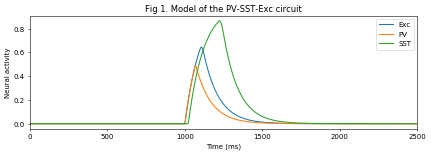

In [7]:
# For single unit, N = 1, therefore put C=None and D=None
C = None
D = None
awc = AWCModel(Cmat = C, Dmat = D)

#Input stimulus
input_tones = [100]
stim_dur = 100
T = awc.params['duration'] = 3500
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext= np.zeros((1,len(t)))
I_ext[0] = thalamic_input(t, dt, input_tones,stim_dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 5
awc.run()

# Fig 1 from Park-Geffen paper
fig, ax = plt.subplots(figsize=(10, 3), dpi=50)
ax.plot(awc.u[0],label = "Exc") 
ax.plot(awc.p[0],label = "PV") 
ax.plot(awc.s[0],label = "SST") 
ax.set(xlabel= "Time (ms)", ylabel ="Neural activity", title= "Fig 1. Model of the PV-SST-Exc circuit", xlim=[0,2500])
ax.legend()
plt.show()  


In [8]:
# Fig 3. The effect of optogenetic manipulations on adaptation to repeated tones

input_tones = [200,600,1000,1400,1800,2200,2600,3000] #times(ms) for input
C = None
D = None
awc = AWCModel(Cmat = C, Dmat = D)

stim_dur = 100 #duration of each sound
T = awc.params['duration'] = 3500
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext= np.zeros((1,len(t)))
I_ext[0] = thalamic_input(t, dt, input_tones, stim_dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 5

#optogenetic stimulation on-off times
laser_on_times =[] 
for i in range(len(input_tones)):
    laser_on_times.append([input_tones[i]-100,input_tones[i]+100])

In [9]:
#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u[0],awc.p[0],awc.s[0]

#PV off
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  I_opto(t,laser_on_times,val=-2)
awc.run()
pv_u,pv_p,pv_s  = awc.u[0],awc.p[0],awc.s[0]

#SST off
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  I_opto(t,laser_on_times,val=-1)
awc.run()
sst_u,sst_p,sst_s = awc.u[0],awc.p[0],awc.s[0]

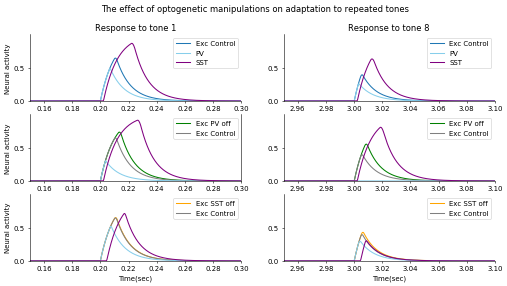

In [10]:
# Fig 3. The effect of optogenetic manipulations on adaptation to repeated tones
fig, ax = plt.subplots(3,2,figsize=(12, 6), dpi=50)
t = np.linspace(0,3.5,len(control_u))
ax[0][0].plot(t,control_u,label="Exc Control")
ax[0][0].plot(t,control_p,label="PV",color="skyblue")
ax[0][0].plot(t,control_s,label="SST",color="purple")
ax[0][0].set(title = "Response to tone 1", ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False) 
ax[0][0].legend()


ax[0][1].plot(t,control_u,label="Exc Control")
ax[0][1].plot(t,control_p,label="PV",color="skyblue")
ax[0][1].plot(t,control_s,label="SST",color="purple")
ax[0][1].set(title = "Response to tone 8", xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].legend()

ax[1][0].plot(t,pv_u,label="Exc PV off",color="green")
ax[1][0].plot(t,control_u,label="Exc Control",color="Gray")
ax[1][0].plot(t,pv_p,color="skyblue")
ax[1][0].plot(t,pv_s,color="purple")
ax[1][0].set( ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[1][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False) 
ax[1][0].legend()


ax[1][1].plot(t,pv_u,label="Exc PV off",color="green")
ax[1][1].plot(t,control_u,label="Exc Control",color="Gray")
ax[1][1].plot(t,pv_p,color="skyblue")
ax[1][1].plot(t,pv_s,color="purple")
ax[1][1].set(xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].legend()

ax[2][0].plot(t,sst_u,label="Exc SST off",color="orange")
ax[2][0].plot(t,control_u,label="Exc Control",color="Gray")
ax[2][0].plot(t,sst_p,color="skyblue")
ax[2][0].plot(t,sst_s,color="purple")
ax[2][0].set(xlabel = "Time(sec)", ylabel="Neural activity",xlim = [0.15,0.30],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[2][0].spines['top'].set_visible(False)
ax[2][0].spines['right'].set_visible(False) 
ax[2][0].legend()


ax[2][1].plot(t,sst_u,label="Exc SST off",color="orange")
ax[2][1].plot(t,control_u,label="Exc Control",color="Gray")
ax[2][1].plot(t,sst_p,color="skyblue")
ax[2][1].plot(t,sst_s,color="purple")
ax[2][1].set(xlabel="Time(sec)", xlim = [2.950,3.100],ylim=[0,1],yticks =(np.arange(0, 1, step=0.5)))
ax[2][1].spines['top'].set_visible(False)
ax[2][1].spines['right'].set_visible(False) 
ax[2][1].legend()
fig.suptitle("The effect of optogenetic manipulations on adaptation to repeated tones")
plt.show() 

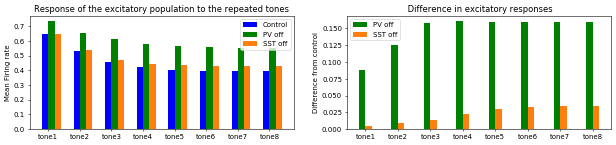

In [11]:
max_values = find_max([control_u,pv_u,sst_u],input_tones,dt,200)
labels = ['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0]
pv_off = max_values[1]
sst_off = max_values[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,2,figsize=(15,3),dpi=50)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_off, width, label='PV off',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_off, width, label='SST off',color='C1')
ax[0].set(ylabel ='Mean Firing rate', title="Response of the excitatory population to the repeated tones",xticks=x,xticklabels=labels)
ax[0].legend()

diff_p = ax[1].bar(x - (width/2), pv_off-control, width, label='PV off',color="green")
diff_s = ax[1].bar(x + (width/2), sst_off-control, width, label='SST off',color='C1')
ax[1].set(ylabel ='Difference from control', title=" Difference in excitatory responses",xticks=x,xticklabels=labels)
ax[1].legend()
plt.show()

#### Excitatory-inhibitory balance in the rate and spiking models

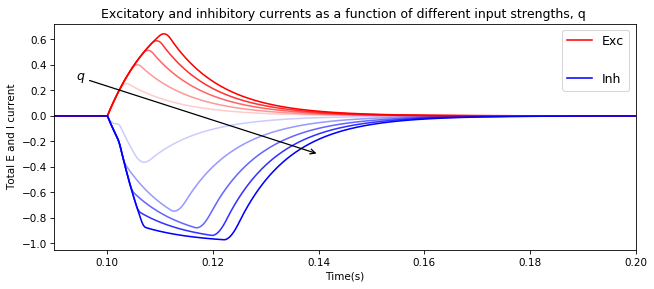

In [12]:
#Fig 9. Excitatory-inhibitory balance in the rate models
from matplotlib.legend_handler import HandlerTuple as ht
C = None
D = None
awc = AWCModel(Cmat = C, Dmat = D)

#Input stimulus
input_tones = [100]
stim_dur = 100
T = awc.params['duration'] = 500
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext= np.zeros((1,len(t)))
I_ext[0] = thalamic_input(t, dt, input_tones,stim_dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
q_list = [1,2,3,4,5]

e_i_balance = np.zeros((5,2,len(t)-1))
fig,ax = plt.subplots(figsize=(10,4),dpi = 75)
x_range = np.linspace(0,0.5,len(t)-1)
m = [0.2,0.4,0.6,0.8,1.0]
for i,q in enumerate(q_list):
    awc.params['q'] = q
    awc.run()
    e_i_balance[i][0] = awc.u[0]
    e_i_balance[i][1] = awc.p[0] + awc.s[0]
    p1, = ax.plot(x_range,e_i_balance[i][0],alpha=m[i],color="red")
    p2, = ax.plot(x_range,-e_i_balance[i][1],alpha=m[i],color="blue")
    ax.set(xlabel = "Time(s)", ylabel = "Total E and I current", xlim=[0.09,0.2],title="Excitatory and inhibitory currents as a function of different input strengths, q ") 
ax.legend(((p1), (p2)), ('Exc', 'Inh'), numpoints=1, labelspacing=2, fontsize=12)
ax.annotate(
     # Label and coordinate
    '${ q}$', xy=(0.14,-0.3),xytext=(0.095,0.3) ,
    horizontalalignment="center",fontsize=12,
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=1.2),
    va='center'
    )
   
plt.show(block=False)

    

## Three unit model

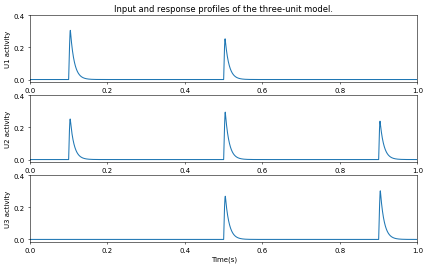

In [13]:
# For three unit, N = 3
N = 3
C = [[0,1,0],[1,0,1],[0,1,0]] #Represents the connectivity to other unit
C = np.asarray(C)
D = np.zeros((3,3))

#Model
awc = AWCModel(Cmat = C, Dmat = D)

#Fig 2 Input and response profiles of the three-unit model.

input_tones = [100, 500, 900]
dur = 50
T = awc.params['duration'] = 3500
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext= np.zeros((N,len(t)))
I_ext[0] = thalamic_input(t, dt, [input_tones[0]], dur, tau_q = 10, q = 1.3)
I_ext[1] = thalamic_input(t, dt, [input_tones[1]], dur, tau_q = 10, q = 1.3)
I_ext[2] = thalamic_input(t, dt, [input_tones[2]], dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 1.3

awc.run()


fig, ax = plt.subplots(3,1,figsize=(10, 6), dpi=50)
t = np.linspace(0,3.5,len(awc.u[0]))
ax[0].plot(t,awc.u[0],label="Unit 1")
ax[0].set(ylabel="U1 activity", xlim=[0,1], yticks =(np.arange(0, max(awc.u[0])+0.1, step=0.2)),title="Input and response profiles of the three-unit model.")

ax[1].plot(t,awc.u[1],label="Unit 2")
ax[1].set(ylabel="U2 activity", xlim=[0,1], yticks =(np.arange(0, max(awc.u[0])+0.1, step=0.2)))

ax[2].plot(t,awc.u[2],label="Unit 3")
ax[2].set(ylabel="U3 activity",  xlim=[0,1], xlabel = "Time(s)", yticks =(np.arange(0, max(awc.u[0])+0.1, step=0.2)) )

plt.show()  


#### Differential effects of interneuron suppression in stimulus-specific adaptation(SSA)

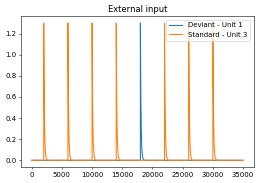

In [14]:
# Fig 4. Summary of SSA in the rate model

t = np.arange(0,T,dt)
I_ext = np.zeros((N, len(t))) #Input   
q = 5
dur = 100
input_tones = [200,600,1000,1400,1800,2200,2600,3000]
deviant_tones = [1800]
standard_tones = [200,600,1000,1400,2200,2600,3000]

I_ext[0] = thalamic_input(t, dt, deviant_tones, dur, tau_q = 10, q = 1.3) #Deviant
I_ext[2]= thalamic_input(t, dt, standard_tones, dur, tau_q = 10, q = 1.3) #Standard
awc.params['I_ext'] = I_ext
awc.params['q'] = 5

fig = plt.subplots(dpi=50)
plt.plot(I_ext[0],label="Deviant - Unit 1")
plt.plot(I_ext[2],label= "Standard - Unit 3")
plt.title("External input")
plt.legend()
plt.show()

laser_on_times =[]
for i in range(len(input_tones)):
    laser_on_times.append([input_tones[i]-100,input_tones[i]+100])

In [15]:
#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV off
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  I_opto(t,laser_on_times,val=-4)
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST off
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  I_opto(t,laser_on_times,val=-2)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

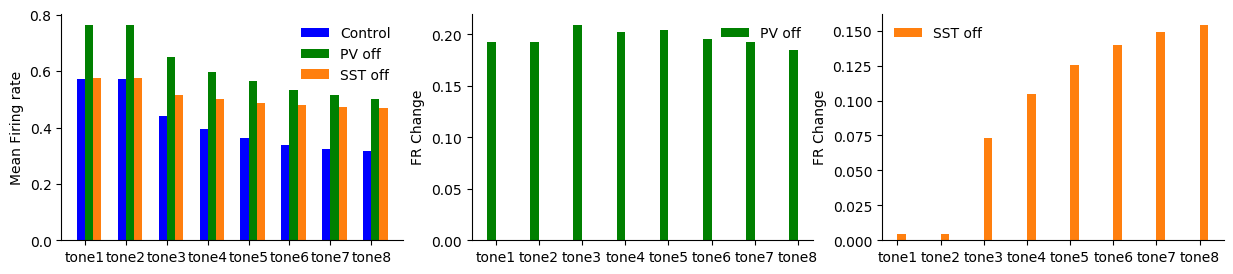

In [16]:
max_values = find_max([control_u[1],pv_u[1],sst_u[1]],input_tones,dt,200)
labels = ['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0]
pv_off = max_values[1]
sst_off = max_values[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,3,figsize=(15,3),dpi=100)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_off, width, label='PV off',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_off, width, label='SST off',color='C1')
ax[0].set_ylabel('Mean Firing rate')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)  

diff_p = ax[1].bar(x - (width/2), pv_off-control, width, label='PV off',color="green")
ax[1].set_ylabel('FR Change')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(frameon=False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)  

diff_s = ax[2].bar(x + (width/2), sst_off-control, width, label='SST off',color='C1')
ax[2].set_ylabel('FR Change')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend(frameon=False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)  

plt.show()

In [17]:
#Prediction - PV On and SST On

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV On
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  I_opto(t,laser_on_times,val=0.5)
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST on
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  I_opto(t,laser_on_times,val=1.2)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

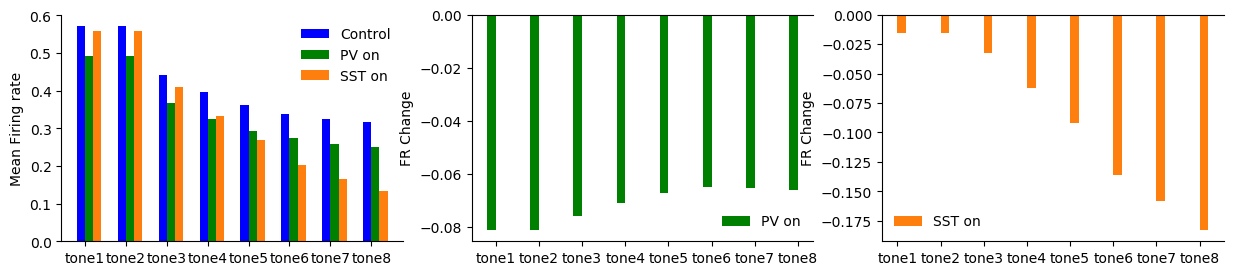

In [18]:
max_values = find_max([control_u[1],pv_u[1],sst_u[1]],input_tones,dt,200)
labels = ['tone1', 'tone2', 'tone3', 'tone4', 'tone5', 'tone6', 'tone7', 'tone8']
control = max_values[0]
pv_on = max_values[1]
sst_on = max_values[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(1,3,figsize=(15,3),dpi=100)
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_on, width, label='PV on',color="green")
s1 = ax[0].bar(x + 3*(width/2), sst_on, width, label='SST on',color='C1')
ax[0].set_ylabel('Mean Firing rate')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)  

diff_p = ax[1].bar(x - (width/2), pv_on-control, width, label='PV on',color="green")
ax[1].set_ylabel('FR Change')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(frameon=False)
ax[1].spines['right'].set_visible(False)  

diff_s = ax[2].bar(x + (width/2), sst_on-control, width, label='SST on',color='C1')
ax[2].set_ylabel('FR Change')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend(frameon=False)
ax[2].spines['right'].set_visible(False)  

plt.show()

#### Differential effects of inhibitory neuron manipulation on cortical forward suppression

In [19]:
# Fig 6. Forward suppression in the rate model

T = awc.params['duration'] = 1250
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext = np.zeros((N, len(t))) #Input   
I = np.zeros((N, len(t))) #Thalamic adapted input I_ext * g
q = 1.3
dur = 50
trial1 = [100,170]
trial2 = [600,670]
trial3 = [1100,1170]
frwd_supp_array = np.zeros((3,len(trial1)*3))


In [20]:
#Trial 1
I_ext[0] = np.zeros((len(t)))
I_ext[1] = thalamic_input(t, dt, [trial1[1]], dur, tau_q = 10, q = 1.3)
I_ext[2] = thalamic_input(t, dt, [trial1[0]], dur, tau_q = 10, q = 1.3) 
awc.params['I_ext'] = I_ext
awc.params['q'] = q

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV off
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  np.ones((len(t)))*(-0.5)
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST off
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  np.ones((len(t)))*(-0.5)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

control_tone1 = find_max([control_u[2],pv_u[2],sst_u[2]],[trial1[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial1[1]],dt,100)
frwd_supp_array[0] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)


In [21]:
#Trial 2
I_ext[0] = np.zeros((len(t)))
I_ext[1] = thalamic_input(t, dt, trial2, dur, tau_q = 10, q = 1.3)
I_ext[2] = np.zeros((len(t)))
awc.params['I_ext'] = I_ext
awc.params['q'] = q

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV off
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  np.ones((len(t)))*(-0.5)
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST off
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  np.ones((len(t)))*(-0.5)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

control_tone1 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial2[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial2[1]],dt,100)
frwd_supp_array[1] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)


In [22]:
#Trial 3
I_ext[0] = thalamic_input(t, dt, [trial3[0]], dur, tau_q = 10, q = 1.3) 
I_ext[1] = thalamic_input(t, dt, [trial3[1]], dur, tau_q = 10, q = 1.3)
I_ext[2] = np.zeros((len(t)))

awc.params['I_ext'] = I_ext
awc.params['q'] = q

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV off
awc.params['opt_SST']  = np.zeros((len(t)))
awc.params['opt_PV'] =  np.ones((len(t)))*(-0.5)
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST off
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST']  =  np.ones((len(t)))*(-0.5)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

control_tone1 = find_max([control_u[0],pv_u[0],sst_u[0]],[trial3[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial3[1]],dt,100)
frwd_supp_array[2] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)


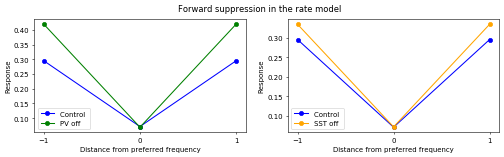

In [23]:
fig,axs = plt.subplots(1,2,figsize=(12,3),dpi=50)
freq_dist = [-1,0,1]
fs = frwd_supp_array
#Measuring from u2 - second tones
control = [fs[0,3], fs[1,3], fs[2,3] ]
pv_off  = [fs[0,4], fs[1,4], fs[2,4] ]
sst_off = [fs[0,5], fs[1,5], fs[2,5] ]

axs[0].plot(freq_dist, control,label='Control ',color="blue",marker="o")
axs[0].plot(freq_dist, pv_off,label='PV off',color="green",marker="o")
axs[0].set(xlabel="Distance from preferred frequency", ylabel ="Response", xticks= (np.arange(-1,1.1,step=1)))
axs[0].legend()

axs[1].plot(freq_dist, control,label='Control ',color="blue",marker="o")
axs[1].plot(freq_dist, sst_off,label='SST off',color="orange",marker="o")
axs[1].set(xlabel="Distance from preferred frequency", ylabel ="Response", xticks= (np.arange(-1,1.1,step=1)))
axs[1].legend()
fig.suptitle("Forward suppression in the rate model")
plt.show()

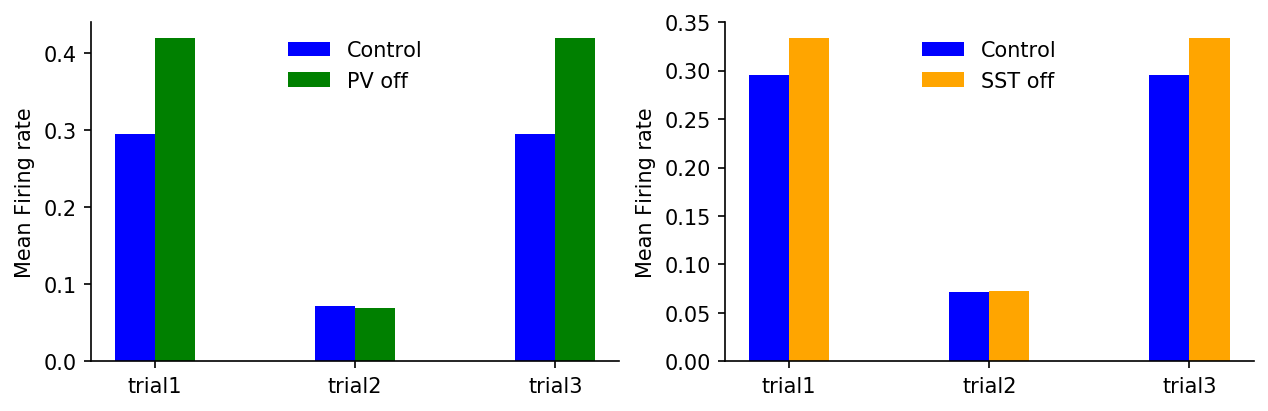

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=150)
labels =["trial1","trial2","trial3"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
control  = [fs[0,3], fs[1,3], fs[2,3] ]
pv_off   = [fs[0,4], fs[1,4], fs[2,4] ]
sst_off  = [fs[0,5], fs[1,5], fs[2,5] ]
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_off, width, label='PV off',color="green")

c1 = ax[1].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[1].bar(x + (width/2), sst_off, width, label='SST off',color="orange")

ax[0].set_ylabel('Mean Firing rate')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)  
ax[1].set_ylabel('Mean Firing rate')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(frameon=False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)  
plt.show()

In [25]:
#Rate model prediction for forward suppression during PV and SST activation.
# Prediction - PV On and SST On
frwd_supp_array = np.zeros((3,len(trial1)*3))

#Trial 1
I_ext[0] = np.zeros((len(t)))
I_ext[1] = thalamic_input(t, dt, [trial1[1]], dur, tau_q = 10, q = 1.3)
I_ext[2] = thalamic_input(t, dt, [trial1[0]], dur, tau_q = 10, q = 1.3) 
awc.params['I_ext'] = I_ext

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV On
awc.params['opt_PV'] = np.ones((len(t)))*(0.5)
awc.params['opt_SST'] = np.zeros((len(t)))
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST On
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST'] = np.ones((len(t)))*(1.2)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s


control_tone1 = find_max([control_u[2],pv_u[2],sst_u[2]],[trial1[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial1[1]],dt,100)
frwd_supp_array[0] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)


In [26]:
#Trial 2
I_ext[0] = np.zeros((len(t)))
I_ext[1] = thalamic_input(t, dt, trial2, dur, tau_q = 10, q = 1.3)
I_ext[2] = np.zeros((len(t)))
awc.params['I_ext'] = I_ext

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV On
awc.params['opt_PV'] = np.ones((len(t)))*(0.5)
awc.params['opt_SST'] = np.zeros((len(t)))
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST On
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST'] = np.ones((len(t)))*(1.2)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

control_tone1 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial2[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial2[1]],dt,100)
frwd_supp_array[1] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)



In [27]:
#Trial 3
I_ext[0] = thalamic_input(t, dt, [trial3[0]], dur, tau_q = 10, q = 1.3) 
I_ext[1] = thalamic_input(t, dt, [trial3[1]], dur, tau_q = 10, q = 1.3)
I_ext[2] = np.zeros((len(t)))
awc.params['I_ext'] = I_ext

#Control - No optogenetic stimulation
awc.params['opt_SST'] = np.zeros((len(t)))
awc.params['opt_PV']  = np.zeros((len(t)))
awc.run()
control_u,control_p,control_s = awc.u,awc.p,awc.s

#PV On
awc.params['opt_PV'] = np.ones((len(t)))*(0.5)
awc.params['opt_SST'] = np.zeros((len(t)))
awc.run()
pv_u,pv_p,pv_s  = awc.u,awc.p,awc.s

#SST On
awc.params['opt_PV'] = np.zeros((len(t)))
awc.params['opt_SST'] = np.ones((len(t)))*(1.2)
awc.run()
sst_u,sst_p,sst_s = awc.u,awc.p,awc.s

control_tone1 = find_max([control_u[0],pv_u[0],sst_u[0]],[trial3[0]],dt,100)
control_tone2 = find_max([control_u[1],pv_u[1],sst_u[1]],[trial3[1]],dt,100)
frwd_supp_array[2] = np.concatenate((control_tone1.ravel(),control_tone2.ravel()),axis=0)


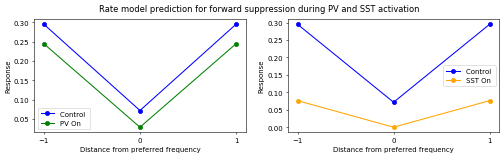

In [28]:
fig,axs = plt.subplots(1,2,figsize=(12,3),dpi=50)
freq_dist = [-1,0,1]
fs = frwd_supp_array
#Measuring from u2 - second tones
control = [fs[0,3], fs[1,3], fs[2,3] ]
pv_on   = [fs[0,4], fs[1,4], fs[2,4] ]
sst_on  = [fs[0,5], fs[1,5], fs[2,5] ]

axs[0].plot(freq_dist, control,label='Control ',color="blue",marker="o")
axs[0].plot(freq_dist, pv_on,label='PV On',color="green",marker="o")
axs[0].set(xlabel="Distance from preferred frequency", ylabel ="Response", xticks= (np.arange(-1,1.1,step=1)))
axs[0].legend()

axs[1].plot(freq_dist, control,label='Control ',color="blue",marker="o")
axs[1].plot(freq_dist, sst_on,label='SST On',color="orange",marker="o")
axs[1].set(xlabel="Distance from preferred frequency", ylabel ="Response", xticks= (np.arange(-1,1.1,step=1)))
axs[1].legend()
fig.suptitle("Rate model prediction for forward suppression during PV and SST activation")
plt.show()

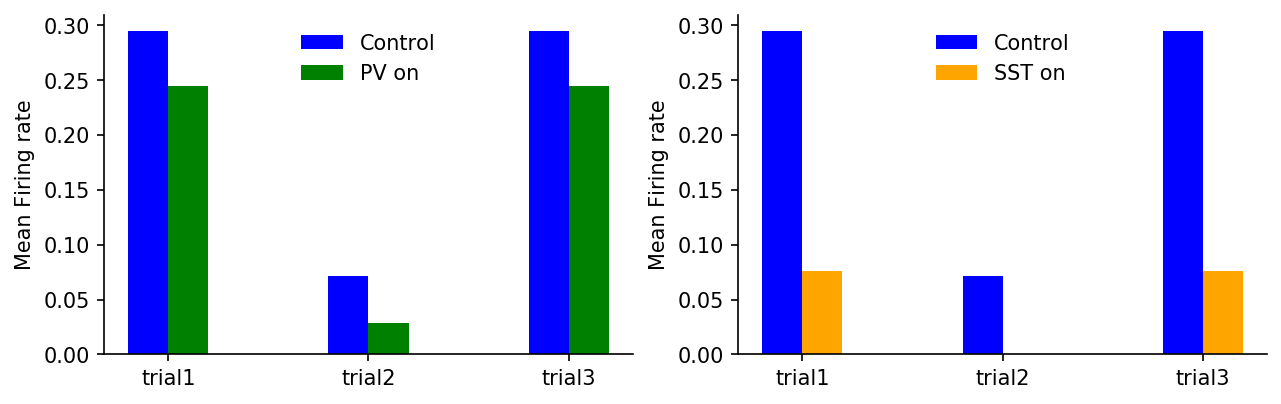

In [29]:
fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=150)
labels =["trial1","trial2","trial3"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
control = [fs[0,3], fs[1,3], fs[2,3] ]
pv_on  = [fs[0,4], fs[1,4], fs[2,4] ]
sst_on = [fs[0,5], fs[1,5], fs[2,5] ]
c1 = ax[0].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[0].bar(x + (width/2), pv_on, width, label='PV on',color="green")

c1 = ax[1].bar(x - width/2, control, width, label='Control',color="blue")
p1 = ax[1].bar(x + (width/2), sst_on, width, label='SST on',color="orange")

ax[0].set_ylabel('Mean Firing rate')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)  
ax[1].set_ylabel('Mean Firing rate')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(frameon=False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)  
plt.show()

#### PVs enhance feedforward functional connectivity

SSA and forward suppression belonged to the weak inhibitory regime, whereas tuning-curve adaptation and PV activation belonged to the strong inhibition regime.

In [30]:
# Fig 8. Activation of PVs enhanced feedforward connectivity in the model.
N = 3
C = [[0,1,0],[1,0,1],[0,1,0]] #Represents the connectivity to other unit
C = np.asarray(C)
D = np.zeros((3,3))

#Model
awc = AWCModel(Cmat = C, Dmat = D)
awc.params['w_ep'] = 3
awc.params['w_es'] = 3
awc.params['s_th'] = 0

input_tones = [100]
dur = 50
T = awc.params['duration'] = 500
dt = awc.params['dt'] = 0.1
t = np.arange(0,T,dt)
I_ext= np.zeros((N,len(t)))

#Control
awc.params['opt_PV']  = np.zeros((len(t)))
awc.params['opt_SST']  = np.zeros((len(t)))
I_ext[1] = thalamic_input(t, dt, input_tones, dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 5
awc.run()
control_u = awc.u


#PV off
awc.params['opt_PV'] = np.ones((len(t)))*(-2)
I_ext[1] = thalamic_input(t, dt, input_tones, dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 5
awc.run()
pvoff_u = awc.u

#PV On
awc.params['opt_PV'] = np.ones((len(t)))*(2)
I_ext[1] = thalamic_input(t, dt, input_tones, dur, tau_q = 10, q = 1.3)
awc.params['I_ext'] = I_ext
awc.params['q'] = 5
awc.run()
pvon_u = awc.u


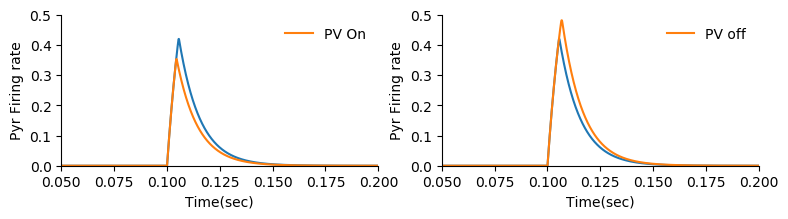

In [31]:
# Fig 8. Activation of PVs enhanced feedforward connectivity in the model. 
fig,axs = plt.subplots(1,2,figsize=(9,2),dpi=100)
t = np.linspace(0,0.5,len(control_u[0]))

axs[0].plot(t,control_u[1])
axs[0].plot(t,pvon_u[1],label="PV On",)
axs[0].set( xlabel="Time(sec)", ylabel="Pyr Firing rate", xlim = [0.05,0.2],ylim=[0,0.5])
axs[0].legend(frameon=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)  

axs[1].plot(t,control_u[1])
axs[1].plot(t,pvoff_u[1],label="PV off")
axs[1].set( xlabel="Time(sec)", ylabel="Pyr Firing rate", xlim = [0.05,0.2],ylim=[0,0.5])
axs[1].legend(frameon=False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.show()